# Final Project
### DTSA 5510 - Unsupervised Machine Learning, as part of the MS-DS program
#### University of Colorado, Boulder
##### October 2024


## Introduction

For this project, I will be working with the Wine dataset from the University of California, Irvine. I will be using a few different clustering methods on the dataset and tuning some hyperparameters to optimize classification accuracy.

I chose this dataset because I personally enjoy drinking wine and pairing it with food. While this is a simple clustering project, a lot can be done with machine learning for food and drink recommender systems. A quick internet search brings up several different projects, both small and large. As this is my first course in unsupervised learning, I'll start with something basic.

### The data

The data was accessed from the [University of California at Irvine repository](https://archive.ics.uci.edu/dataset/109/wine).

It is available under the [Creative Commons License](https://creativecommons.org/licenses/by/4.0/legalcode).

A short blurb about the data from the website from which it was accessed:
* "These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines."
* "In a classification context, this is a well posed problem with "well behaved" class structures. (This is) a good data set for first testing of a new classifier, but not very challenging."

##### Data features, all of which are numerical:
* Alcohol: Alcohol content by volume
* Malicacid: Organic compound in grapes that contributes to the sour taste of fruit, makes the wine acidic.
* Ash: According to the [International Organization of Vine and Wine](https://www.oiv.int/standards/compendium-of-international-methods-of-wine-and-must-analysis/annex-a-methods-of-analysis-of-wines-and-musts/section-2-physical-analysis/ash-%28type-i%29), the ash content is defined as "all those products remaining after igniting the residue left after the evaporation of the wine. The ignition is carried out in such a way that all the cations (excluding the ammonium cation) are converted into carbonates or other anhydrous inorganic salts." So it's a bi-product of the chemical analysis process, not an ingredient!
* Alcalinity-of-ash: pH of the above.
* Magnesium: A mineral naturally occurring in grapes
* Total_phenols: [US National Libary of Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7866523/) describes polyphenols as phenolic compounds which contribute to the colour, flavour, and taste of wine.
* Flavanoids: A subgroup of polyphenols
* Nonflavanoid_phenols: Another subgroup of polyphenols
* Proanthocyanins: Principal phenols in red wine
* Color-intensity: Strength of colour
* Hue: The colour of the wine
* 0D280_0D315_of_diluted_wines. There wasn't actually a description of this feature that I could find.
* Proline: Naturally occuring amino acid

##### Target data, or ground-truth labels
* The dataset contains observations which are all one of 3 different cultivars. I'll use these labels to assess how accurate my clustering model works.

### Methods

First, I imported the necessary packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN

I accessed the data directly from the online repository:

In [2]:
# !pip install ucimlrepo  ## uncomment to install required repository
from ucimlrepo import fetch_ucirepo

In [3]:
# read in data
wine = fetch_ucirepo(id=109)
# wine # calling the wine object displays meta data
# wine data is also in the data folder and can be accessed there :)

### EDA

Next I took a look at the data to see if there were any readily apparent patterns:

In [4]:
X = wine.data.features
y = wine.data.targets

X.head(3)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malicacid                     178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  0D280_0D315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
dtypes: fl

There are no missing values in the dataset, and all features appear to be of the correct datatype.

I created some visualizations for each feature:

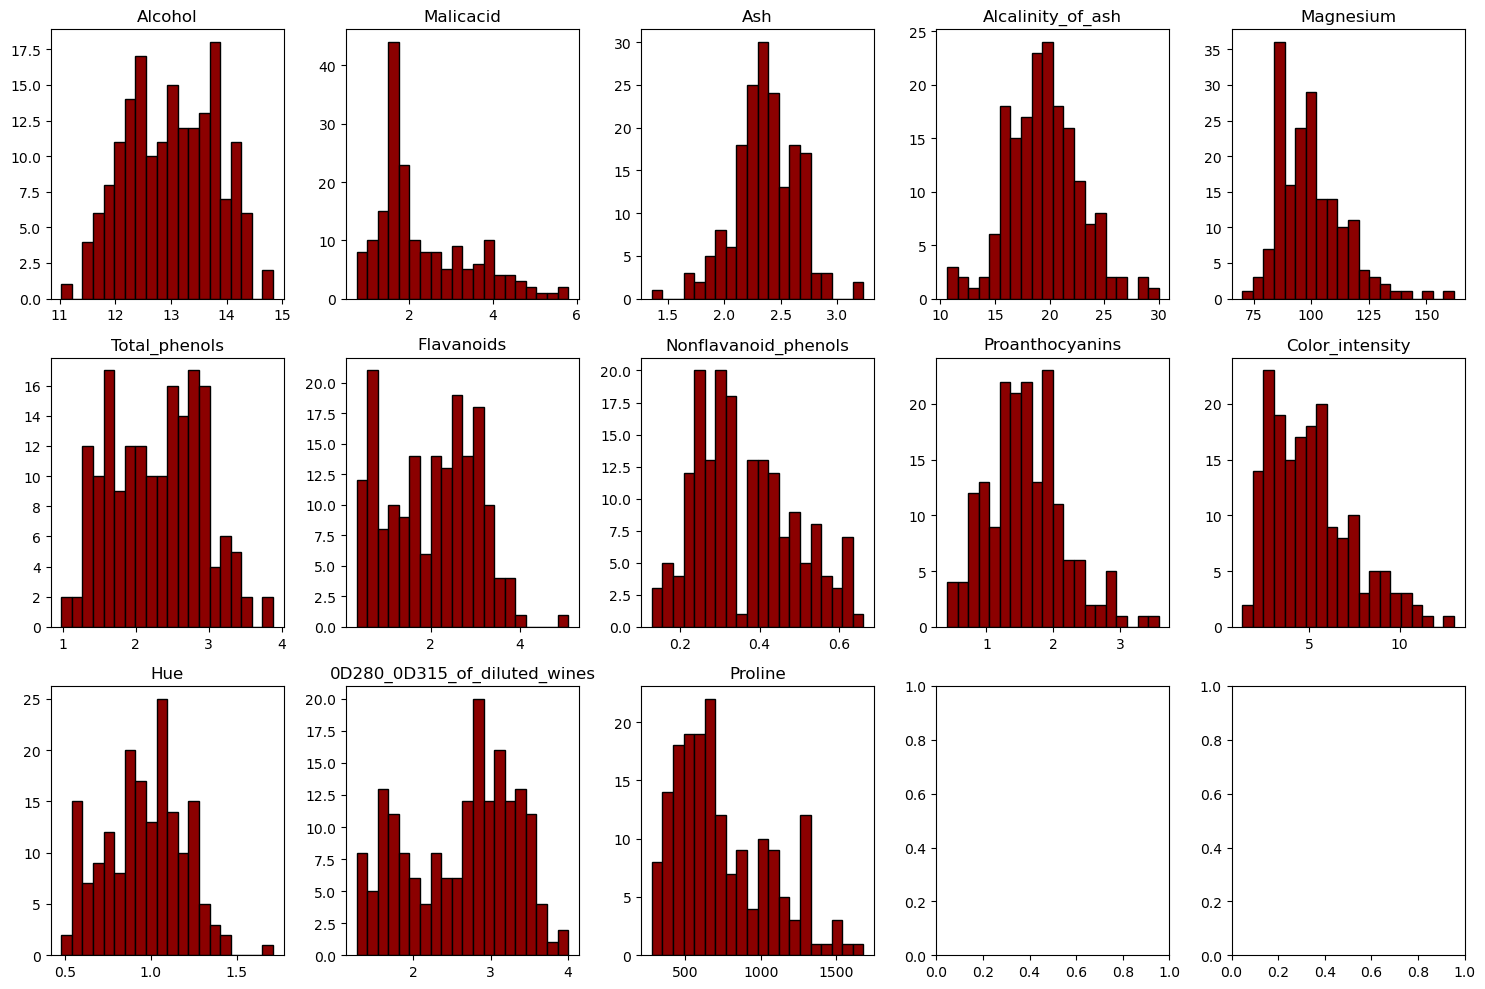

In [6]:
# 3 by 5 grid for plots
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

# flatten for easy iteration
axes = axes.ravel()

# histograms for each feature
for i, col in enumerate(X.columns):
    axes[i].hist(X[col], bins=20, color='darkred', edgecolor='black')
    axes[i].set_title(col)

# layout
plt.tight_layout()
plt.show()

##### Distribution of classes or ground-truth labels:

C:\Users\bergs\AppData\Local\Temp\ipykernel_23520\913791095.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Class',


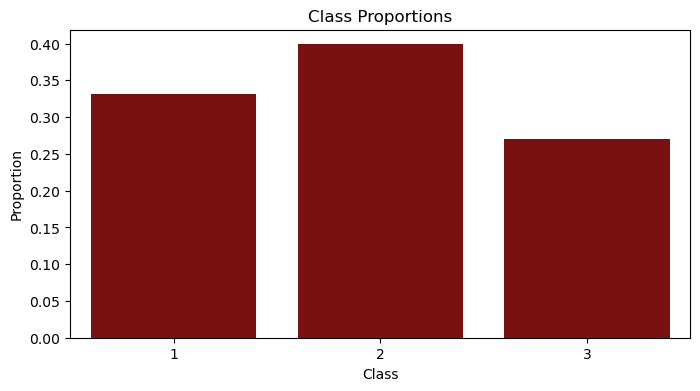

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming class_proportions is already computed
class_proportions = y.value_counts() / len(y)

# Reset the index to get a simple DataFrame for plotting
class_proportions_df = class_proportions.reset_index()
class_proportions_df.columns = ['Class', 'Proportion']

# Create a horizontal bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x = 'Class', 
            y = 'Proportion', 
            data = class_proportions_df, 
            palette=['darkred'] * len(class_proportions))

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Class Proportions')

# Show the plot
plt.show()

At this point, nothing in the features stood out to me as showing a pattern. The classes are a little imbalance but not drastically so.

Time to move on to clustering!

In [8]:
# normalize 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# reshape y to 1D array for evaluation
y_true = y.values.ravel() 

## Evaluation:
* One method of evaluation is the Adjusted Rand Index (ARI).  ARI measures the similarity between two data clusterings and evaluated how well the clusters agree with the reference clustering, or ground truth labels. Values range from -1 to 1, with 1 being a perfect fit, 0 being no better than random chance, and -1 being worse than random chance.
* Another method of evaluation is the Adjusted Mutual Information (AMI). AMI is a measure used to evaluate the similarity between two clusters, taking into consideration the amount of information shared between them. Values range from 0 to 1, with 1 being perfect agreement between two clusters (ie, they are identical) and 0 being that the agreement between the two clusters are no better than random chance.


### KMeans Clustering
The first type of clustering I did was KMeans. Because I know there are 3 types of cultivars, I set n_clusters to 3. I had tried different numbers of max iterations and found that convergence was reached after just 4 iterations.

In [10]:
# cluster model
kmeans = (KMeans(n_clusters = 3,
                 max_iter = 4,
                 random_state = 5510)
         )
# fit
kmeans.fit(X_scaled)

# get labels
labels = kmeans.labels_

# score
ari = adjusted_rand_score(y_true, labels)
ami = adjusted_mutual_info_score(y_true, 
                                 labels, 
                                 average_method = 'arithmetic')

print(f'Adjusted Rand Index (ARI): {ari:.4f}')
print(f'Adjusted Mutual Information (AMI): {ami:.4f}\n')

Adjusted Rand Index (ARI): 0.8804
Adjusted Mutual Information (AMI): 0.8595



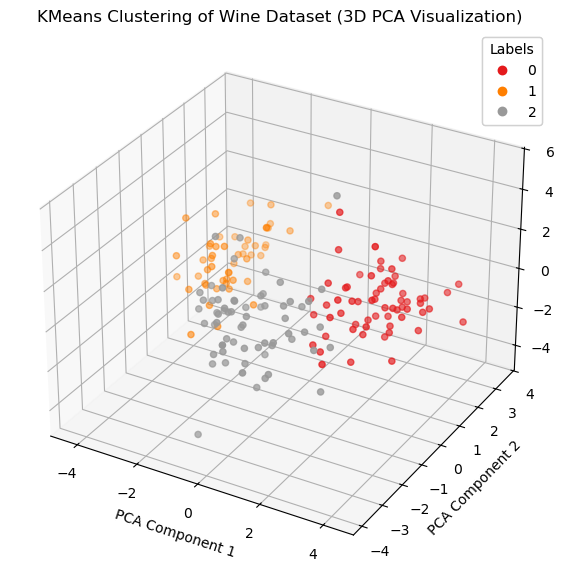

In [11]:
# plot
pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection = '3d')

scatter = ax.scatter(X_pca[:, 0], 
                     X_pca[:, 1], 
                     X_pca[:, 2],
                     c = labels, 
                     cmap = 'Set1')

ax.set_title('KMeans Clustering of Wine Dataset (3D PCA Visualization)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

legend = ax.legend(*scatter.legend_elements(), title = 'Labels')
ax.add_artist(legend)

kmeans_pca = fig

plt.show()

### Hierarchical Clustering

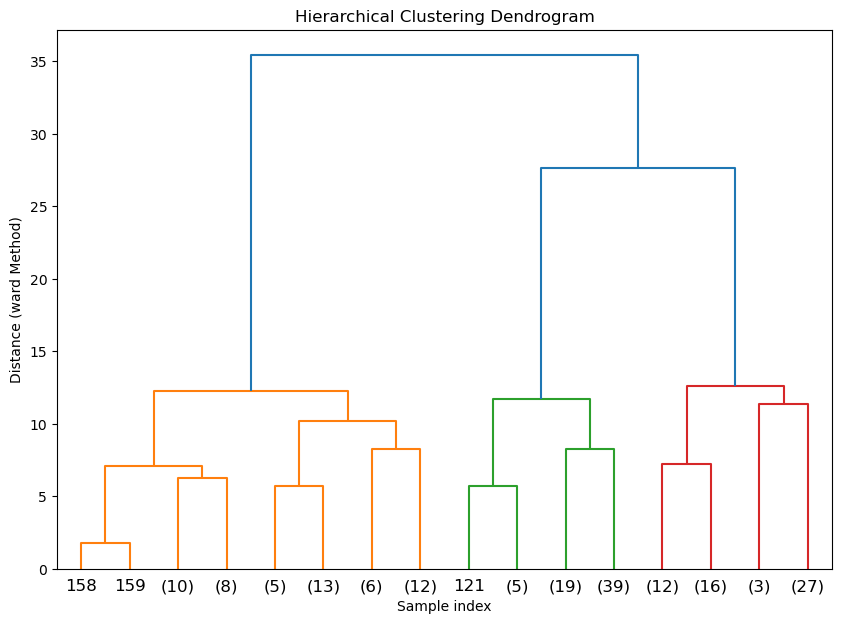

Adjusted Rand Index (ARI) for ward method: 0.7899
Adjusted Mutual Information (AMI) for ward method: 0.7842


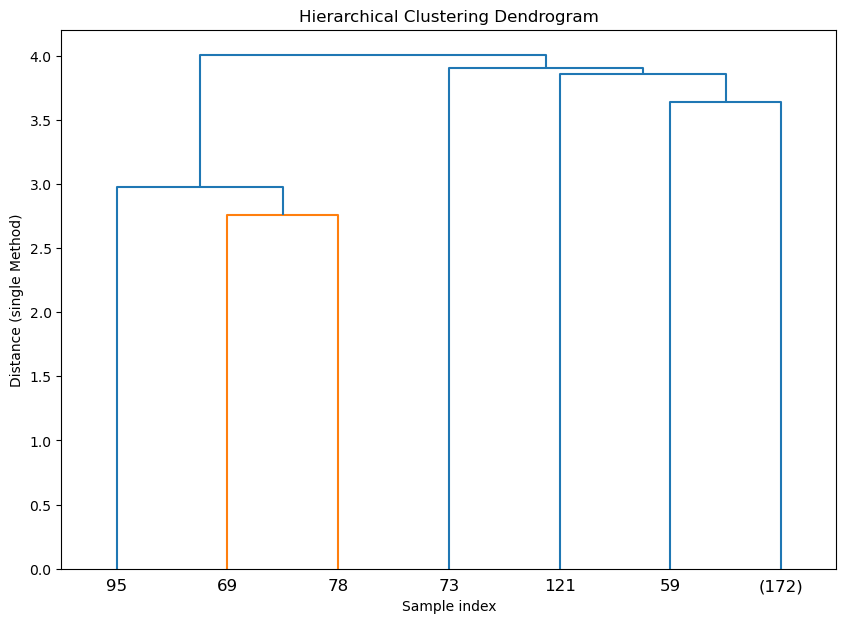

Adjusted Rand Index (ARI) for single method: -0.0068
Adjusted Mutual Information (AMI) for single method: 0.0130


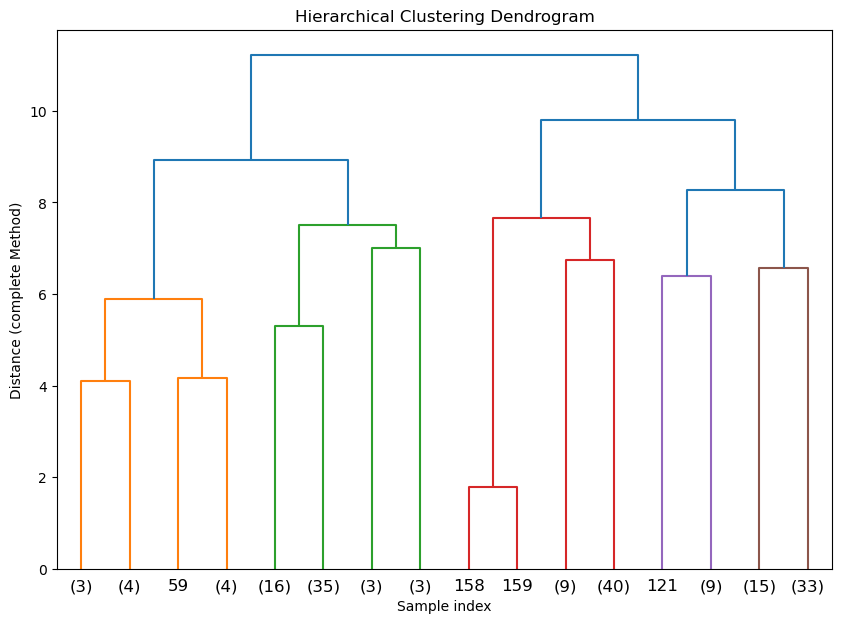

Adjusted Rand Index (ARI) for complete method: 0.5771
Adjusted Mutual Information (AMI) for complete method: 0.6103


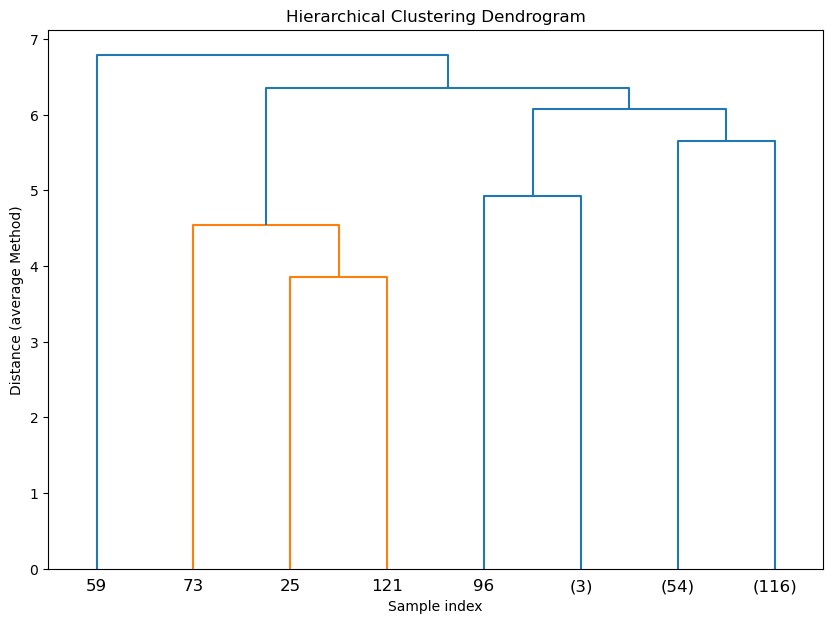

Adjusted Rand Index (ARI) for average method: -0.0054
Adjusted Mutual Information (AMI) for average method: -0.0038


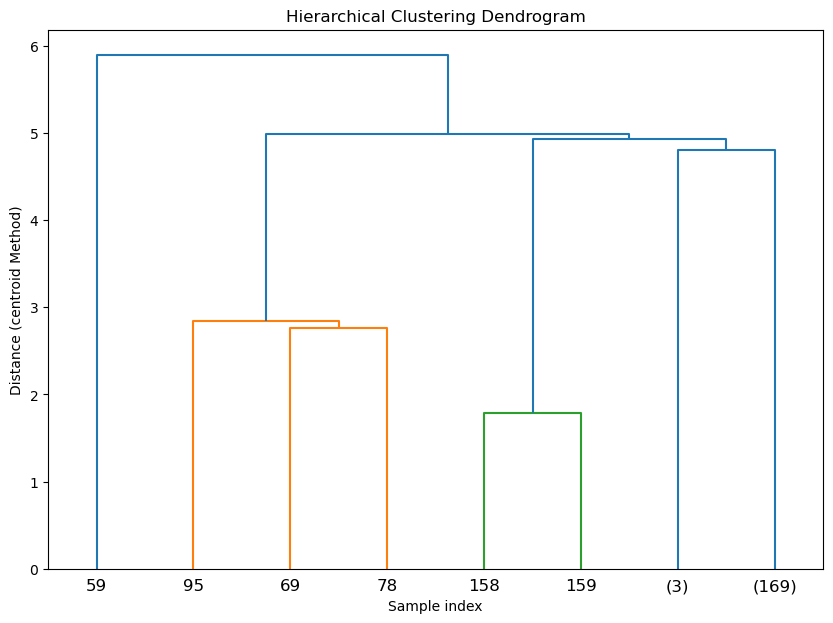

Adjusted Rand Index (ARI) for centroid method: -0.0068
Adjusted Mutual Information (AMI) for centroid method: 0.0130


,Linkage Method,ARI Score,AMI Score
0,ward,0.789933,0.784208
1,single,-0.006814,0.013045
2,complete,0.577144,0.610290
3,average,-0.005442,-0.003783
4,centroid,-0.006814,0.013045


In [12]:
# linkage methods
methods = ['ward', 'single', 
           'complete', 'average', 
           'centroid']
ari_scores = []
ami_scores = []

# loop through methods, plot and evaluate
for method in methods:
    Z = linkage(X_scaled, method = method)

    # extract cluster labels
    cluster_labels = fcluster(Z, 
                              t = 3, 
                              criterion = 'maxclust') 

    # calculate ari and ami scores
    ari = adjusted_rand_score(y_true, cluster_labels)
    ari_scores.append(ari)
    
    ami = adjusted_mutual_info_score(y_true, cluster_labels)
    ami_scores.append(ami)
    
    # plot dendrogram
    plt.figure(figsize = (10, 7))
    dendrogram(Z, truncate_mode = 'level', p = 3)  
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel(f'Distance ({method} Method)')
    plt.show()

    # print scores
    print(f'Adjusted Rand Index (ARI) for {method} method: {ari:.4f}')
    print(f'Adjusted Mutual Information (AMI) for {method} method: {ami:.4f}')

hierarch_results_df = pd.DataFrame({
    'Linkage Method': methods,
    'ARI Score': ari_scores,
    'AMI Score': ami_scores
})

hierarch_results_df

The ward method in hierarchical clustering results in the highest scores, but still not as good as the kMeans clustering. The 'complete' method wasn't too bad. The average and centroid method were not good at all.

C:\Users\bergs\AppData\Local\Temp\ipykernel_23520\3958845726.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X_pca[:, 0],
C:\Users\bergs\miniconda3\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


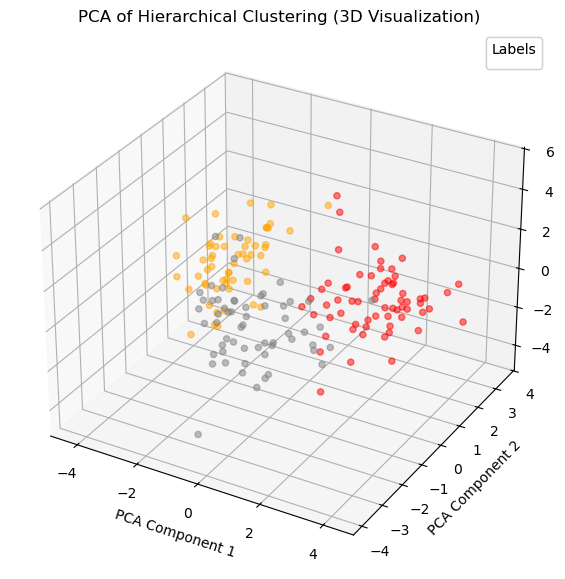

In [13]:
# plot hier clusters

Z = linkage(X_scaled,
            method = 'ward')
cluster_labels = fcluster(Z,
                          t = 3,
                          criterion = 'maxclust')

pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection = '3d')

# switch around colours for consistency with other pca plots
custom_colours = []
for label in cluster_labels:
    if label == 1:
        custom_colours.append('orange')  
    elif label == 2:
        custom_colours.append('red')  
    else:
        custom_colours.append('gray')  

scatter = ax.scatter(X_pca[:, 0], 
                     X_pca[:, 1], 
                     X_pca[:, 2], 
                     c = custom_colours, 
                     cmap = 'Set1',
                     alpha = 0.5)

ax.set_title('PCA of Hierarchical Clustering (3D Visualization)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

legend = ax.legend(*scatter.legend_elements(), 
                   title = 'Labels')
ax.add_artist(legend)

plt.show()

### Agglomerative Clustering

In [14]:
# linkages and distances
methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'manhattan', 'cosine']  

# store results
results = []

# loop through linkages and distances
for method in methods:
    for metric in distance_metrics:
        # ward linkage requirs euclidean dist
        if linkage == 'ward' and metric != 'euclidean':
            continue
        
        # agglom clustering
        agg_clustering = (AgglomerativeClustering(n_clusters = 3, 
                                                  metric = metric, 
                                                  linkage = method))
        
        try:
            clusters = agg_clustering.fit_predict(X_scaled)

            # calculate ari and ami scores
            ari_score = adjusted_rand_score(y_true, clusters)
            ami_score = adjusted_mutual_info_score(y_true, clusters)
            results.append((method, metric, ari_score, ami_score))
            print(f"Linkage: {method}, Metric: {metric}, ARI: {ari_score:.4f}, AMI: {ami_score:.4f}")
        
        except Exception as e:
            print(f"Error with Linkage: {method}, Metric: {metric}: {str(e)}")

# best combination based on ari and ami
best_ari_combination = max(results, key=lambda x: x[2])
best_ami_combination = max(results, key=lambda x: x[3])
best_ari_combination
best_ami_combination

Linkage: ward, Metric: euclidean, ARI: 0.7899, AMI: 0.7842
Error with Linkage: ward, Metric: manhattan: manhattan was provided as metric. Ward can only work with euclidean distances.
Error with Linkage: ward, Metric: cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Linkage: complete, Metric: euclidean, ARI: 0.5771, AMI: 0.6103
Linkage: complete, Metric: manhattan, ARI: 0.4855, AMI: 0.6154
Linkage: complete, Metric: cosine, ARI: 0.5972, AMI: 0.6291
Linkage: average, Metric: euclidean, ARI: -0.0054, AMI: -0.0038
Linkage: average, Metric: manhattan, ARI: 0.4730, AMI: 0.6149
Linkage: average, Metric: cosine, ARI: 0.7847, AMI: 0.7850
Linkage: single, Metric: euclidean, ARI: -0.0068, AMI: 0.0130
Linkage: single, Metric: manhattan, ARI: -0.0038, AMI: -0.0033
Linkage: single, Metric: cosine, ARI: -0.0068, AMI: 0.0130


('average', 'cosine', 0.7847063550518786, 0.7849864479314348)

* Best: Ward linkage and Euclidean distance performed about as well as the Average linkage and cosine distance, but still not as good as kMeans.
* Complete linkage overall wasn't bad across the different distance methods.
* Single linkage - not good at all.
* Average linkage had a surprising range of scores across the different distance methods, with the best being cosine distance and worst being Euclidean. Interesting.

C:\Users\bergs\AppData\Local\Temp\ipykernel_23520\1753219425.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(X_pca[:, 0],
C:\Users\bergs\miniconda3\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


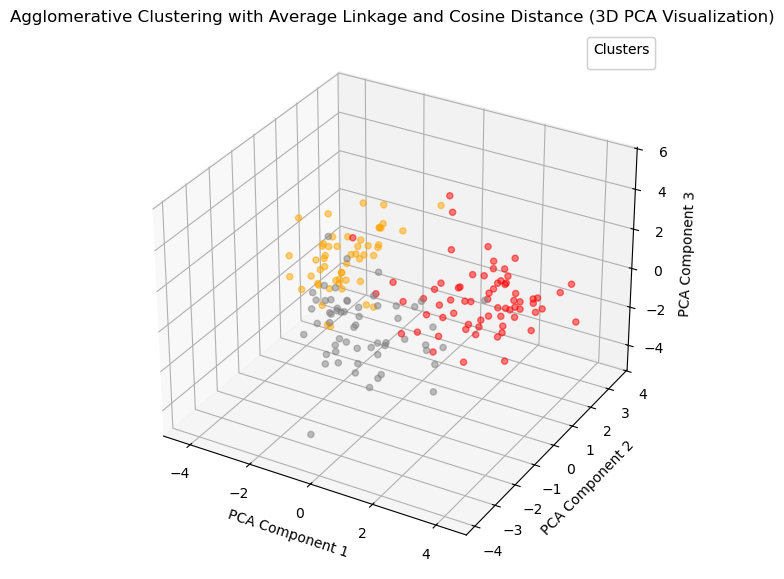

In [15]:
agg_clustering = AgglomerativeClustering(n_clusters = 3, 
                                         metric = 'cosine', 
                                         linkage = 'average')

clusters = agg_clustering.fit_predict(X_scaled)

pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# switch around colours for consistency with other pca plots
custom_colours = []
for label in clusters:
    if label == 0:
        custom_colours.append('red')  
    elif label == 1:
        custom_colours.append('gray')  
    else:
        custom_colours.append('orange')   

# Scatter plot with custom palette
scatter = ax.scatter(X_pca[:, 0], 
                     X_pca[:, 1], 
                     X_pca[:, 2], 
                     c = custom_colours, 
                     cmap = 'Set1', 
                     alpha = 0.5)

# Customize the title and labels
ax.set_title('Agglomerative Clustering with Average Linkage and Cosine Distance (3D PCA Visualization)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Display the legend
legend = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend)

# Show the plot
plt.show()

## Conclusion:

In this project, I used three different unsupervised machine learning clustering methods on the wine data set: kMeans clustering, hierarchical clustering, and agglomerative clustering. Because I had ground-truth labels (the target), I evaluated the models' performances using the Adjusted Rand Index and the Adjusted Mutual Information.

* kMeans clustering had the best performance with an ARI score of 0.8804 and an AMI score of 0.8595.
* Agglomerative clustering had the second best performance using the average linkage and cosine metric, with an ARI score of 0.7847 and an AMI score of 0.7850.
* Hierarchical clustering using the Ward method and Euclidean distance had an ARI score of 0.7899 and an AMI score of	0.7842, which is pretty similar to the agglomerative model performance.